In [1]:
# Importing the libraries 
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, RepeatedStratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(color_codes = True)
from imblearn.over_sampling import SMOTE
import shap
from imblearn.pipeline import Pipeline 

import warnings
warnings.filterwarnings("ignore")

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv("online_shoppers_intention.csv")

In [3]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [5]:
df.Month.value_counts()

May     3364
Nov     2998
Mar     1907
Dec     1727
Oct      549
Sep      448
Aug      433
Jul      432
June     288
Feb      184
Name: Month, dtype: int64

In [6]:
# Changing the boolean datatypes into integer datatypes
df['Weekend'] = df['Weekend'].astype('int64')
df['Revenue'] = df['Revenue'].astype('int64')

In [7]:
# Changing the other categorical variables into integer datatypes using ordinal encoding
# This transforms categorical value to numerical value in ordered sets through a dictionary

Month_dict = {'Feb' : 2, 'Mar': 3, 'May': 5, 'June': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

df['Month'] = df.Month.map(Month_dict)

VisitorType_dict = {'Other': 0, 'New_Visitor' : 1, 'Returning_Visitor': 2}

df['VisitorType'] = df.VisitorType.map(VisitorType_dict)

In [8]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,2,1,1,1,1,2,0,0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,2,2,2,1,2,2,0,0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,2,4,1,9,3,2,0,0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,2,3,2,2,4,2,0,0
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,2,3,3,1,4,2,1,0


In [9]:
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,7.651987,2.124006,2.357097,3.147364,4.069586,1.848824,0.232603,0.154745
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,3.392841,0.911325,1.717277,2.401591,4.025169,0.376989,0.422509,0.361676
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,5.000000,2.000000,2.000000,1.000000,2.000000,2.000000,0.000000,0.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,7.000000,2.000000,2.000000,3.000000,2.000000,2.000000,0.000000,0.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,11.000000,3.000000,2.000000,4.000000,4.000000,2.000000,0.000000,0.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,12.000000,8.000000,13.000000,9.000000,20.000000,2.000000,1.000000,1.000000


In [10]:
#Use StandardScaler to standardize the data into a normal distribution because the features are measured at different scales
X = df.drop('Revenue', 1)
y = df['Revenue']
columns = X.columns
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_std = pd.DataFrame(X_std, columns = columns)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state = 7 )



In [12]:
pipeline = Pipeline([
    ('model', LogisticRegression(random_state = 7))])

In [13]:
for scoring in["accuracy", "f1"]:
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)
    scores = cross_val_score(pipeline, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
    print("Model", scoring, " mean=", scores.mean())

Model accuracy  mean= 0.881758455169124
Model f1  mean= 0.4837155864433769


In [14]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('model', LogisticRegression(random_state=7))])

In [15]:
y_preds = pipeline.predict(X_test)

print(accuracy_score(y_test, y_preds))
print(f1_score(y_test, y_preds))
print(classification_report(y_test, y_preds))


0.8819951338199513
0.5008576329331047
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      2077
           1       0.75      0.38      0.50       389

    accuracy                           0.88      2466
   macro avg       0.82      0.68      0.72      2466
weighted avg       0.87      0.88      0.86      2466



The Logistic Regression model tends to predict class 0 rather than class 1, because of the imbalanced data.

' Percentage of no transaction is 85%. Percentage of transaction is 15% (conversion rate). Our classes are imbalanced.'

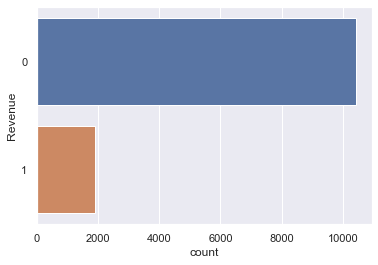

In [16]:
sns.countplot(y = 'Revenue', data = df)
df.Revenue.value_counts()

""" Percentage of no transaction is 85%. Percentage of transaction is 15% (conversion rate). Our classes are imbalanced."""

Oversampling

In [17]:
from imblearn.pipeline import Pipeline 
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

                                
#steps = [('over', SMOTE()), ('model', LogisticRegression(random_state = 11))]
pipeline_os = Pipeline([('over', SMOTE(random_state = 7)),
    ('model', LogisticRegression(random_state = 7))])                              
                                

In [18]:
for scoring in["accuracy", "f1"]:
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)
    scores = cross_val_score(pipeline_os, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
    print("Model", scoring, " mean=", scores.mean())

Model accuracy  mean= 0.8681058899607172
Model f1  mean= 0.6317578761469534


In [19]:
pipeline_os.fit(X_train,y_train)

Pipeline(steps=[('over', SMOTE(random_state=7)),
                ('model', LogisticRegression(random_state=7))])

In [20]:
y_preds = pipeline_os.predict(X_test)

print(accuracy_score(y_test, y_preds))
print(f1_score(y_test, y_preds))
print(classification_report(y_test, y_preds))

0.8726682887266829
0.6423690205011389
              precision    recall  f1-score   support

           0       0.95      0.90      0.92      2077
           1       0.58      0.72      0.64       389

    accuracy                           0.87      2466
   macro avg       0.76      0.81      0.78      2466
weighted avg       0.89      0.87      0.88      2466



The results show that the use of oversampling helps the Logistic Regression model to predict the class 1 better. 

Hyperparameter tuning

In [50]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)

In [32]:
param_grid = {'model__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
             'model__solver':['lbfgs', 'liblinear'],
             'model__penalty':['l2'],
             'model__random_state':[7]}

In [51]:
acc_clf = GridSearchCV(pipeline_os, param_grid = param_grid, cv = cv, scoring='accuracy', n_jobs=-1)
f1_clf =  GridSearchCV(pipeline_os, param_grid = param_grid, cv = cv, scoring='f1', n_jobs=-1)


In [52]:
acc_clf.fit(X_train, y_train)
f1_clf.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=7),
             estimator=Pipeline(steps=[('over', SMOTE(random_state=7)),
                                       ('model',
                                        LogisticRegression(random_state=7))]),
             n_jobs=-1,
             param_grid={'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'model__penalty': ['l2'], 'model__random_state': [7],
                         'model__solver': ['lbfgs', 'liblinear']},
             scoring='f1')

In [35]:
print(acc_clf.best_params_)
print(acc_clf.best_score_)
print(f1_clf.best_score_)


{'model__C': 10, 'model__penalty': 'l2', 'model__random_state': 7, 'model__solver': 'lbfgs'}
0.8682072584351217
0.6320093062261741


In [26]:
test_score = acc_clf.score(X_test, y_test)
print(f'Cross-validation score: {acc_clf.best_score_}\nTest score: {test_score}')

Cross-validation score: 0.8682072584351217
Test score: 0.8726682887266829


In [27]:
#Test results after the model is trained with oversampling and GridSearchCV
pred_test = acc_clf.predict(X_test)
print(accuracy_score(y_test, pred_test))
print(f1_score(y_test, pred_test))
print(classification_report(y_test, pred_test))

0.8726682887266829
0.6423690205011389
              precision    recall  f1-score   support

           0       0.95      0.90      0.92      2077
           1       0.58      0.72      0.64       389

    accuracy                           0.87      2466
   macro avg       0.76      0.81      0.78      2466
weighted avg       0.89      0.87      0.88      2466



For fold 1:
Accuracy: 0.9334955393349554


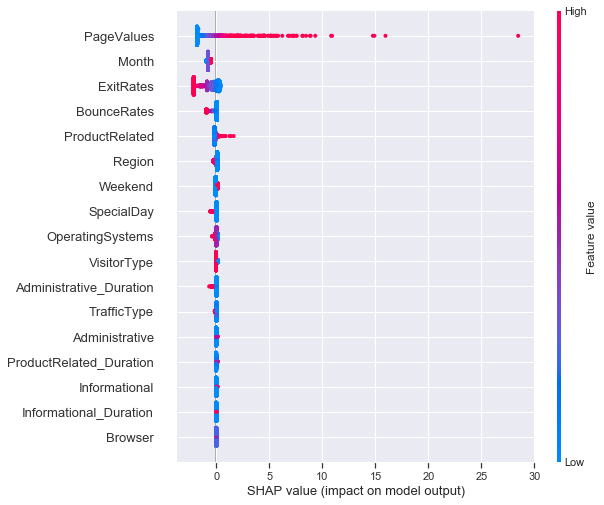

For fold 2:
Accuracy: 0.9237631792376317


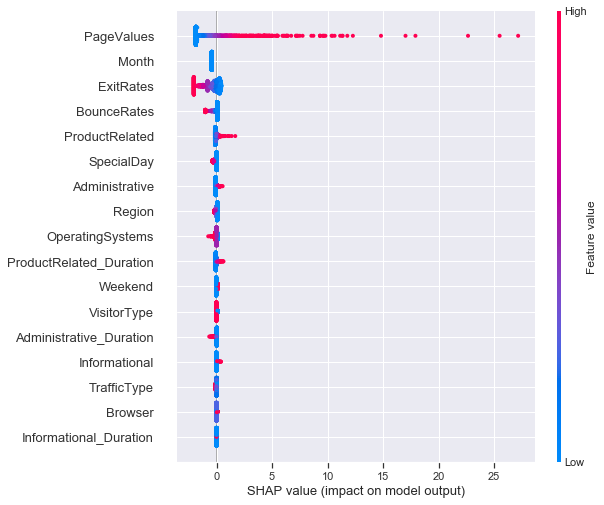

For fold 3:
Accuracy: 0.8402270884022709


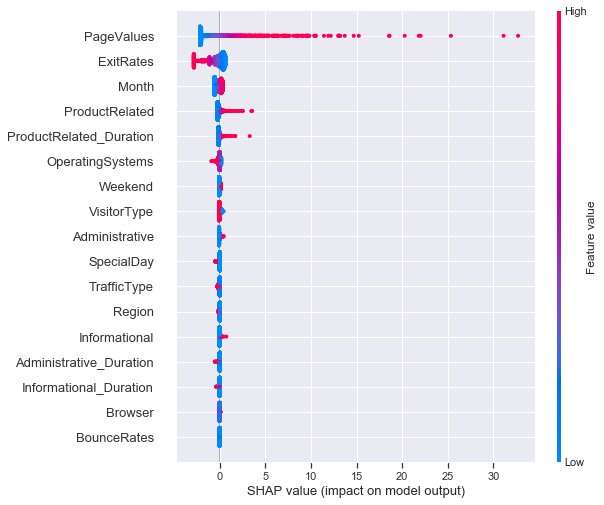

For fold 4:
Accuracy: 0.8126520681265207


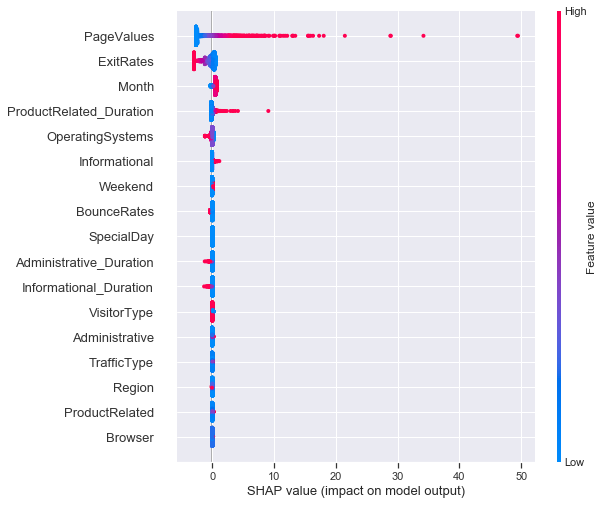

For fold 5:
Accuracy: 0.8195458231954582


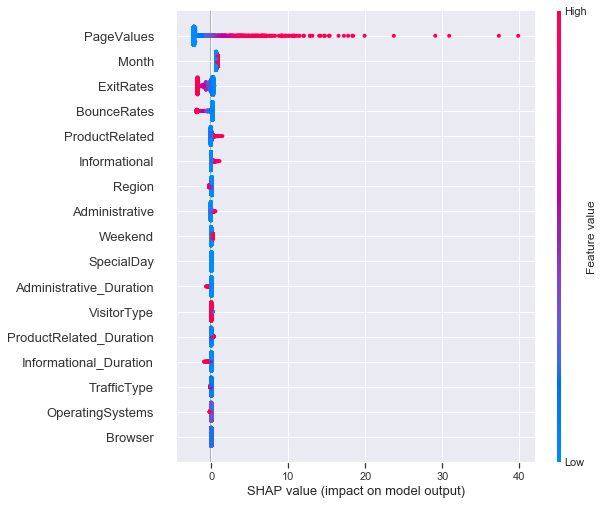

In [28]:
#SHAP values with oversampling the training data and the tuned hyperparameters
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
os = SMOTE(random_state = 7)

kf = KFold(n_splits=5)

for fold, (train_index, test_index) in enumerate(kf.split(X_std, y), 1):
    X_train = X_std.iloc[train_index, :]
    y_train = y[train_index] 
    X_test = X_std.iloc[test_index, :]
    y_test = y[test_index]  # See comment on ravel and  y_train
    X_train_oversampled, y_train_oversampled = os.fit_resample(X_train, y_train)
    X_train_oversampled = pd.DataFrame(data=X_train_oversampled,columns=columns )
    y_train_oversampled= pd.DataFrame(data=y_train_oversampled,columns=['Revenue'])
    X_train_os = X_train_oversampled
    y_train_os = y_train_oversampled['Revenue']
    model = LogisticRegression(C = 10, penalty = 'l2', solver= 'lbfgs') 
    model.fit(X_train_os, y_train_os )  
    print(f'For fold {fold}:')
    y_pred = model.predict(X_test)
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    explainer = shap.LinearExplainer(model, X_train_os, feature_dependence="independent")
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test)
    
    

The accuracy score for the first fold is the highest, indicating that PageValues, Month, and ExitRates are the most important features.

In [29]:
# Feature importance scores
shap_sum = (shap_values).mean(axis=0)
importance_df = pd.DataFrame([X_std.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

,column_name,shap_importance
10,Month,0.681065
9,SpecialDay,0.042773
4,ProductRelated,0.041467
2,Informational,0.015856
16,Weekend,0.012705
5,ProductRelated_Duration,0.01247
15,VisitorType,0.000993
0,Administrative,0.000989
1,Administrative_Duration,0.00013
12,Browser,-0.000255


In [30]:
# Feature importance scores with absolute values
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X_std.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

,column_name,shap_importance
8,PageValues,2.450473
10,Month,0.681065
7,ExitRates,0.299182
6,BounceRates,0.230285
4,ProductRelated,0.089219
2,Informational,0.076838
13,Region,0.071718
0,Administrative,0.058777
16,Weekend,0.053846
9,SpecialDay,0.042773
